In [1]:
import numpy as np
import trackpy as tp
import nplocate as nl
import matplotlib.pyplot as plt
import sys

# Anomaly Detection



When we finished the tracking, it is unavoidable that the final result will contain **terrible** tracking result.

The idea is that, after tracking, we get a collection of coordinates, say $\{ \mathbf{r}_i \}$, we can calculate a lot of features from $\{ \mathbf{r}_i \}$, say $\{ \mathbf{f}_i \}$.

If we have a lot of $\{ \mathbf{f}_i \}$, it is expected that their distribution will be gaussian. And the points lie on the tail of the distribution is likely to be <big>outliers</big>.

We can try to reject those outliers to improve the accuracy of the tracking.

## Get tracking result.

In [2]:
img = np.load('image.npy')
img = nl.fix_intensity(img)
diameter = 11
xyz = tp.locate(img, diameter=diameter)
xyz = np.array(xyz)[:, :3]
xyz_tp = xyz.copy()
should_add = True
r_model = 2 * diameter
iter_num = 0
while should_add:
    n0 = xyz.shape[0]
    xyz = nl.add(
        positions=xyz,
        image=img,
        r_model=r_model,
        diameter=diameter,
        locate_func=lambda im : np.array(tp.locate(im, diameter))[:, :3],
        threshold=0
    )
    n1 = xyz.shape[0]
    should_add = n1 > n0
    iter_num += 1
#xyz = nl.refine(xyz, img, r_model, diameter)

## Calculate some features


> This Function is Python-3 Only!


Now we calculate some values to characterise the particle locations. Specifically, we look at the voxel intensity distribution around every particle locations.

One example of such characterisation is the figure 2 in [Crocker & Grier's particle tracking paper](https://www.sciencedirect.com/science/article/abs/pii/S0021979796902179). The figure below is a slight different version,

![](http://www.physics.emory.edu/faculty/weeks//idl/3d/plot34.gif)

It is quite clear that there are <big>two clusters</big>, and it is very reasonable to think the smaller clusters are wrong trcking results.

`nplocate` offers a class to calculate the various features for the particle centres. Let's re-create the above figure for our system and see how it behaves.

In [3]:
# We firsty create an instance of ParticleFeatures.
# This contains all the possible features we can calculate

pf = nl.ParticleFeatures(xyz, img, 8)

now we plot the two features designed by Crocker and Grier.

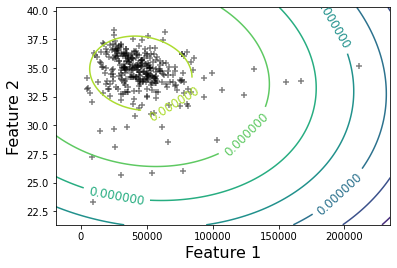

In [4]:
X = np.array((pf.m0, pf.m2))
nl.feature_plot_2d(X)

Looking at the above figure, it is very tempting to suspect that there are some <big>outliers</big>. And [they should be quite far away from the central cluster](https://en.wikipedia.org/wiki/Anna_Karenina_principle). One may even try to exclude them for further calculation.

This procedure is actually called the anomaly detection is the machine learning society. What you can do is fit tie distribution of the points using a joint gaussian distribution, and remove the points whose probability values are small.

## A lot of features

Instead of just using <font color='tomato'><big>2</big></font> features, I acturally designed <font color='teal'><big>36</big></font> features for each particle.

These features are stored in a big numpy array whose shape is `(4, 9, particle_number)`. And their are summarised as below.


```
   dr2 * intensity  ───────────────────┐
 dr2xy * intensity  ─────────────────┐ │
   dz2 * intensity  ───────────────┐ │ │
   dy2 * intensity  ─────────────┐ │ │ │
   dx2 * intensity  ───────────┐ │ │ │ │
    dz * intensity  ─────────┐ │ │ │ │ │
    dy * intensity  ───────┐ │ │ │ │ │ │
    dx * intensity  ─────┐ │ │ │ │ │ │ │
         intensity  ───┐ │ │ │ │ │ │ │ │
                    ┌─┬▼─▼─▼─▼─▼─▼─▼─▼─▼─┐
                    │ │0 1 2 3 4 5 6 7 8 │
                    ├─┼──────────────────┤
              mean  │0│f00    ....   f08 │
          variance  │1│        .         │
              skew  │2│         .        │
          kurtosis  │3│f30    ....   f38 │
                    └─┴──────────────────┘
```

Additionally, for every feature, if all of its values were positive, I took its logarithm so that its shape looks more gaussian. This is a trick in machine learning.

Let's see how the following two features behave,

1. The average intensity (`features[0, 0]`)
2. The skewness of the z-position weighted intensity(`features[2, 3]`)

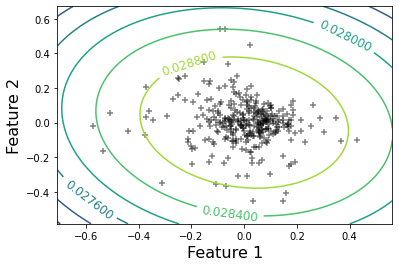

In [5]:
X = np.array((pf.features[0, 0], pf.features[2, 3]))
nl.feature_plot_2d(X)

The distribution looks reasonable. Here the contour shows the probability values from a gaussian fit. We can think of getting rid of particles, whose value is below 0.0296 for instance

# Visualising the probabilities

Let's use all the 36 features! The result will be a 36-dimensional plot so we can't really visualise it. But we can calculate the probability value corresponding to each particles.

The following line shows the distribution of the probability values.

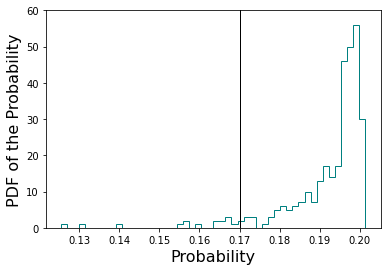

In [6]:
P = pf.get_probability()
cutoff = 0.17
plt.plot((cutoff, cutoff), (0, 80), color='k', lw=1)
plt.hist(P, histtype='step', bins=50, color='teal')
plt.ylabel('PDF of the Probability', fontsize=16)
plt.xlabel('Probability', fontsize=16)
plt.ylim(0, 60)
plt.show()

Let's see the outlier

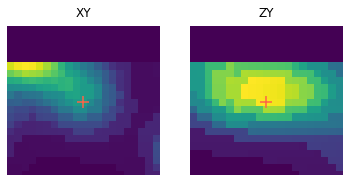

In [7]:
outliers = xyz[P < cutoff]
chosen = outliers[np.random.randint(0, len(outliers))]
nl.see_particle(chosen, img, 10)

It looks like there is only a half particle there, because the location is approaching the bottom.


The following images shows the pictures that are of high probabilities 

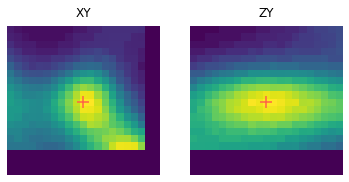

In [8]:
normal = xyz[P > cutoff]
chosen = normal[np.random.randint(0, len(normal))]
nl.see_particle(chosen, img, 10)

Let's caculate the g(r) before and after removing some outliers

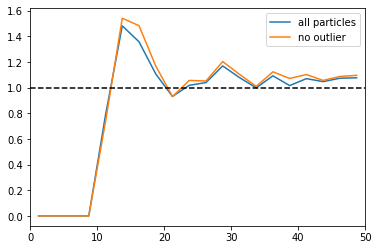

In [9]:
plt.plot(*nl.get_gr(xyz, 50, 21), label='all particles')
plt.plot(*nl.get_gr(xyz[P > cutoff], 50, 21), label='no outlier')
plt.plot((0, 50), (1, 1), color='k', ls='--')
plt.xlim(0, 50)
plt.legend()
plt.show()

# Use PCA to reduce the highly correlated features


There are a lot of highly correlated features in our calculating. For instance, f00 and f10 are quite correlated

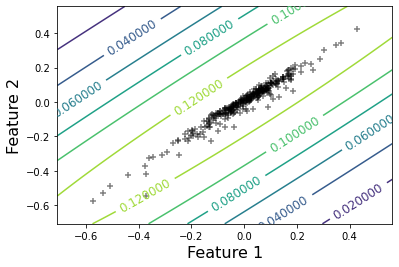

In [10]:
X = np.array((pf.features[0, 0], pf.features[0, 7]))
nl.feature_plot_2d(X)

We can do a quick PCA on the features and see how the retained variance varies with the number of dimensions

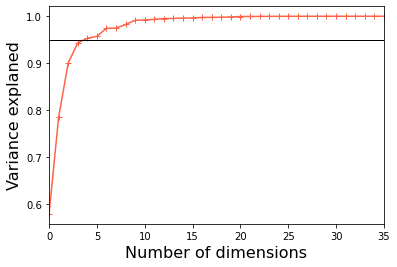

In [11]:
features = pf.features.reshape(36, pf.features.shape[-1])

cov = (features @ features.T) / features.shape[1]

u, s, vh = np.linalg.svd(cov)
plt.plot(1 - s / s.sum(), color='tomato', marker="+")
plt.plot((0, 35), (0.95, 0.95), color='k', lw=1)
plt.xlim(0, 35)
plt.xlabel("Number of dimensions", fontsize=16)
plt.ylabel("Variance explaned", fontsize=16)
plt.show()

It seems that we only need 5 dimensions to describe the data pretty well, with 95% variances retained.

The `ParticleFeatures` offered a method to cacluate the probabilities from the reduced dimensional space.

(3, 316)


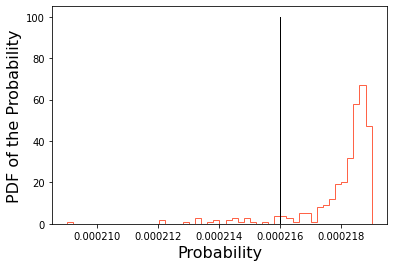

In [12]:
P_red = pf.get_probability_reduced(0.90)
cutoff_red = 2.16e-4
plt.plot((cutoff_red, cutoff_red), (0, 100), color='k', lw=1)
plt.hist(P_red, histtype='step', bins=50, color='tomato')
plt.ylabel('PDF of the Probability', fontsize=16)
plt.xlabel('Probability', fontsize=16)
plt.show()

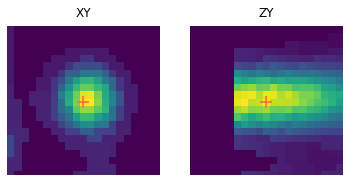

In [13]:
outliers = xyz[P_red < cutoff_red]
chosen = outliers[np.random.randint(0, len(outliers))]
nl.see_particle(chosen, img, 10)

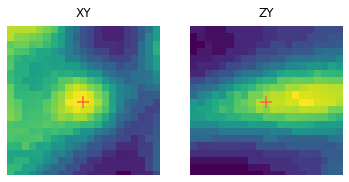

In [14]:
outliers = xyz[P_red > cutoff_red]
chosen = outliers[np.random.randint(0, len(outliers))]
nl.see_particle(chosen, img, 10)

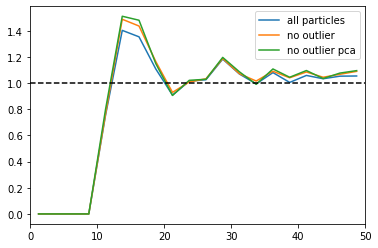

In [15]:
plt.plot(*nl.get_gr(xyz, 50, 21), label='all particles')
plt.plot(*nl.get_gr(xyz[P > cutoff], 50, 21), label='no outlier')
plt.plot(*nl.get_gr(xyz[P_red > cutoff_red], 50, 21), label='no outlier pca')
plt.plot((0, 50), (1, 1), color='k', ls='--')
plt.xlim(0, 50)
plt.legend()
plt.show()